# Homework 3 Part 2

## Course Name: Deep Learning
#### Lecturers: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Khoramnejad, Mehran Sarmadi, Zahra Rahimi

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---


#Text Generation

<p align='justify'>Text generation task involves generating new text based on a given input or a prompt. It is a natural language processing (NLP) task that aims to generate coherent and contextually relevant text.

In text generation, a model is trained on a large corpus of text data and learns the patterns and structures of the language. This model can then be used to generate new text by sampling from the learned distribution of words or characters.

Text generation has various applications, including chatbots, language translation, poetry generation, and content creation. It can be implemented using different techniques such as `recurrent neural networks (RNNs)`, `transformers`, and `Markov chains`.

The goal of text generation is to produce text that is fluent, coherent, and contextually relevant. It requires a deep understanding of the language and the ability to generate text that follows grammatical rules and maintains semantic coherence.</p>

##Charachter-level text generation

One stage of the task of text generation is mapping, which can be at the word or character level. At this stage, a number is assigned to each word or character.

In this exercise, we generate text at the character level. Because generating text at the word level, even though it leads to more meaningful outputs, requires a rich dataset with a high number of word repetitions.

We will implement models based on `recurrent networks` for text generation and compare the performance of different models. In the following, we will check the performance of the best models on different datasets and compare the results

The steps of this exercise are as follows:
1. Train RNN and LSTM
2. FineTuning
3. Experiment on different datasets

---
---

#1. Train RNN and LSTM

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np
import pandas as pd
import random
import re
import string

import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load data

- We use the dataset of `Shakespeare's plays` as the main dataset for this exercise

In [2]:
!wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt" -c -P {'data/'}

--2023-12-06 19:23:09--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘data/input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2023-12-06 19:23:09 (15.7 MB/s) - ‘data/input.txt’ saved [1115394/1115394]



- Load data in amout of 30kb for training models

In [3]:
sh_data_file = "./data/input.txt"
sh_data = open(sh_data_file, 'r').read(30000)

##Charachter mapping

- For better performance of the model, we limit the set of allowed characters

In [4]:
chars = list(string.ascii_lowercase + '\n' + ' ' + ':' + '.')
vocab_size = len(chars)


In [5]:
# Mapping of char-index
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

##Preprocessing

In [6]:
def remove_extraneous_characters(data, valid_char_list):
    pattern = f"[^{re.escape(''.join(valid_char_list))}]"
    return re.sub(pattern, '', data)

In [7]:
sh_data = remove_extraneous_characters(sh_data.lower(), chars)
sh_data_size = len(sh_data)

# Extract indexes of data characters
sh_data = list(sh_data)
for i, ch in enumerate(sh_data):
    sh_data[i] = char_to_ix[ch]

sh_data = torch.tensor(sh_data).to(device)
sh_data = torch.unsqueeze(sh_data, dim=1)

sh_data = torch.nn.functional.one_hot(sh_data[:, 0], num_classes=vocab_size).float()
sh_data = sh_data.to(device)

##Modeling

- In this part define RNN and LSTM model, according to the mentioned characteristics and function inputs.


###RNN

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.5)
        self.hidden_state = torch.zeros(self.num_layers, self.hidden_size).to(device)
        # Define self.rnn with model inputs
        # Define self.decoder for decoding output character from last hidden state
        # You can use torch.nn library

        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, dropout=0.5 if self.dropout_enable else 0, batch_first=True)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input_seq):
        # Implement forward part of model and save last hidden state on self.hidden_state
        input_seq = input_seq.float()
        output, self.hidden_state = self.rnn(input_seq, self.hidden_state)
        output = self.decoder(output.squeeze())
        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))

###LSTM

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.5)
        self.hidden_state = None
        # Define self.lstm with model inputs
        # Define self.decoder for decoding output character from last hidden state
        # You can use torch.nn library

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        # Implement forward part of model and save last hidden state on self.hidden_state
        input_seq = input_seq.float()
        lstm_out, _ = self.lstm(input_seq, self.hidden_state)
        output = self.decoder(lstm_out[:,])

        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))

##Training

In [10]:
def print_sample_output(model, data, data_size, test_output_len = 200):
    # Use this function to print sample that model generates from its current hidden state and random input character
    # test_output_len is total num of characters in output test sequence

    test_output = ""
    data_ptr = 0

    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    while True:
        output = model(input_seq)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]

        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr > test_output_len:
            break

    print("Train Sample +++++++++++++++++++++++++++++++++++++++++++++")
    print(test_output)
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

- For construction of each sample in the dataset, the output sequence is
obtained from the shift of one character from the input sequence. For example, when sequence_length is 10 and our text is `Hello world`. The input sequence would be `Hello worl`, and the target sequence `ello world`.

In [11]:
def train_epoch(model, data, data_size, epoch, optimizer, seq_len=200):
    # seq_length is length of training data sequence
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    sample_number = 0
    # Define training process for one epoch of input model
    # At the end of every ten epochs, print current loss and a sample output of the model using print_sample_output function
    # Feed all data sample to model by iterating over input data

    for i in range(0, data_size - seq_len, seq_len):

        inputs = data[i:i+seq_len].to(device)
        targets = data[i+1:i+seq_len+1].to(device)

        if isinstance(model, LSTM):
           model.hidden_state = (torch.zeros(model.num_layers, model.hidden_size).to(device),
          torch.zeros(model.num_layers, model.hidden_size).to(device))

        else:
          model.hidden_state = torch.zeros(model.num_layers, model.hidden_size).to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update total loss and sample number
        total_loss += loss.item()
        sample_number += 1

    if epoch % 10 == 0:
      print(f"Epoch {epoch}, Loss: {total_loss / sample_number}")


    return total_loss / sample_number


In [12]:
def train_rnn(data, data_size, model_save_file):
    # RNN parameters
    hidden_size = 512
    num_layers = 6
    lr = 0.002
    epoch_num = 100
    losses = []

    # Define training process in the specified number of epochs for RNN model
    # Use train_epoch function for train the model for one epoch
    # Use Adam as optimizer
    # Save best model in model_save_file address for next usage
    rnn_model = RNN(input_size= vocab_size, output_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, dropout_enable=True).to(device)
    # Define optimizer and criterion
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # Initialize best loss
    best_loss = float('inf')
    for epoch in range(1, epoch_num + 1):
        loss = train_epoch(rnn_model, data, data_size, epoch, optimizer)
        losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            torch.save(rnn_model.state_dict(), model_save_file)
    return losses



In [17]:
def train_lstm(data, data_size, model_save_file):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.002
    epoch_num = 100
    losses = []

    # Define training process in the specified number of epochs for LSTM model
    # Use train_epoch function for train the model for one epoch
    # Use Adam as optimizer
    # Save best model in model_save_file address for next usage

    lstm_model = LSTM(input_size=vocab_size, output_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, dropout_enable=True).to(device)
    # Define optimizer and criterion
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # Initialize best loss
    best_loss = float('inf')
    for epoch in range(1, epoch_num + 1):
        loss = train_epoch(lstm_model, data, data_size, epoch, optimizer)
        losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            torch.save(lstm_model.state_dict(), model_save_file)

    return losses

### RNN

In [14]:
rnn_sh_losses = train_rnn(sh_data, sh_data_size, './model_sh_rnn.pth')

Epoch 10, Loss: 3.0268634730371935
Epoch 20, Loss: 3.0264059806692187
Epoch 30, Loss: 3.026346037305635
Epoch 40, Loss: 3.026252161223313
Epoch 50, Loss: 3.0260398963402055
Epoch 60, Loss: 3.0262109986666976
Epoch 70, Loss: 3.0288825347505766
Epoch 80, Loss: 3.058523622052423
Epoch 90, Loss: 3.0321784348323426
Epoch 100, Loss: 3.0338939403665477


### LSTM

In [19]:
lstm_sh_losses = train_lstm(sh_data, sh_data_size, './model_sh_lstm.pth')

Epoch 10, Loss: 1.238327407014781
Epoch 20, Loss: 0.3399106505615958
Epoch 30, Loss: 0.14550707437868776
Epoch 40, Loss: 0.05120177885581707
Epoch 50, Loss: 0.6570397399622818
Epoch 60, Loss: 0.017900343020928317
Epoch 70, Loss: 0.018041381923529994
Epoch 80, Loss: 0.01837117595614159
Epoch 90, Loss: 0.01767023476944626
Epoch 100, Loss: 0.0165152225213864


##Generating texts

- A sample text to input the model

In [63]:
input_sample_text = 'First Citizen:\nYou are all resolved rather to die than to famish?\n'

def create_input_sample_dataset(input_sample_text):
    input_sample = remove_extraneous_characters(input_sample_text.lower(), chars)
    input_sample = [char_to_ix[ch] for ch in list(input_sample)]

    input_sample = torch.unsqueeze(torch.tensor(input_sample).to(device), dim=1)
    input_seq = torch.zeros(len(input_sample),vocab_size).to(device)
    for i, index in enumerate(input_sample):
        input_seq[i][index] = 1
    return input_seq

- This function generates the output generated by the model for the input sample, and if the input sample text is not given, it samples a sequence of original data and gives it to the model.

In [59]:
def generate_text(model, data, data_size, input_sample_test = None, output_len=1000):
    model.eval()
    data_ptr = 0
    test_output=""

    if input_sample_test is not None:
        index = 0
        seq_len = len(input_sample_test)
        input_seq = input_sample_test[index : index + seq_len-1]
    else:
        # If input sample not declared, select an initial string from the data of 10 characters randomly
        index = np.random.randint(data_size - 11)
        seq_len = 10
        input_seq = data[index : index + 9]

   # Set last hidden state of model by feeding input sequence to model
    output = model(input_seq)

    # Last charachter feed to model
    if input_sample_test is not None:
        input_seq = input_sample_test[index + seq_len-1 : index + seq_len]
    else:
        input_seq = data[index + seq_len-1 : index + seq_len]

    while True:
        output = model(input_seq)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]
        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr  > output_len:
            break

    print("Eaxmple of generated text --------------------------------------------------------------------------")
    print(test_output)
    print("----------------------------------------------------------------------------------------------------")

### RNN

In [22]:
best_model_rnn =  RNN(vocab_size, vocab_size, 512, 6).to(device)
best_model_rnn.load_model('./model_sh_rnn.pth')
print("best loss", min(rnn_sh_losses))
generate_text(best_model_rnn.to(device), sh_data.to(device), sh_data_size)

best loss 3.025163803429439
Eaxmple of generated text --------------------------------------------------------------------------
sehemogdrtdratu agm elrmhhle te ab mh e
a t
edaetnhmtei
dha cebggr l
:pa ii
t eontda omondae:nt toatc illi
hh:thtui goshgiahhh  t r irh
eauw rwhmdeuhrltth:hhar 
d 
ilfeetno  .fphteodro t aeuc:d.iht ihhemlo:aeonmu tnhhc eeo eihrrkeeemtnee:  oiothn nlxoaaddhetedteiedoh hivhrpicdrh heai: 
ihhohu de
to
 ooeh.eltpu rtnt 
h lyldu:t
w htrdetsfli  ettsad
 ohe.lm thhaem .eawothhe   othoao imw li
tkshyoda.uuairmm rd etardlen
h e m  lltied   ae: ulueam m  t rougeutglot lho.hovynpaegd ngutmae tspethl lit  t sorc  eras  w:hhrh dhdr deh aph he
hhrs mtgaaodaieees
 mhtulodttrauwr ttlhilmc eitieshee
 ke lmeosttiwue w  ilssthkaa ttalddiahrhtrt etn eiewue
i eyh
s hhr  s mef h  ntue thsua ttahsii
wh  
hu
pehhtaay aei
 h a  ii te hgleh t
mrstn
d  amhgwdaotd
u  
tfei dihydtf aaugtpdamntte wrh eimue
hr
h   ethhdhie edeec fr e ieii a gshhd  urnnehad
m:age e ahw
h 
dmhp.  eaktr t smt

### LSTM

In [23]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_lstm.pth')
print("best loss", min(lstm_sh_losses))
generate_text(best_model_lstm.to(device), sh_data.to(device), sh_data_size)

best loss 0.0165152225213864
Eaxmple of generated text --------------------------------------------------------------------------
 cnrbn lgnrl b crn rrrc  rgrib lrrgbnrbnr  r gb rcsr  cgrnrc gnrnrrccr gb nc nrnrnr bnrcg ggnriinrb rgrr r i lrggrccnrc blblggglgrrcgnggrgrrlrcrri bnrgncncicnngcrrc cgc n blribnrlrrrlci rcc bngcgrgrnrn   rg rrrlr rrg nlncrrc nc l rllbn nb  rcrblrn rrrggrrrgnbnrblggn  i g rrgrir     cn gng gnni bn   cg  rc r cr rg gir rgbnlrrgrnr gtnbn rnirrrrircicrbngg n cgrr r  lggrngbnn clrilrcclblgr rnn r rg rccib bnnrrrbnrncn  rrclg nnccr r r r rnclrgbngrrc lrrlgrrrngbglgbnrn r rg r  lrrrirc b nn nrgr lb c  fclnirbn ri cnrnr rrcb  g riucg ircbncbrb cgcccrrrrb b r  crigrgr rrirn rncnc rrc gnr g b c ggrng nnt uli llrlg g l   gccb rcrcrbni rrn n  rlr ncrrgrbnggnrlcrclrib rg rircrncrrcbnr iicl rcncr rcc g r ri ccgb cinclrgrcri   nncrnng  lgrlr   rrcnrggn gi rrrrrrcgcirgncblrgc rg rccg  rgi gcgnbgnig gl cicrbnr b bfrrlig rg c bn nrrclgbnbnrcntr nin   tcngcgirtggg b gll trrrgr

## Plotting the losses

In [24]:
def plot_losses(losses):
    xpoints = np.array(range(len(losses)))
    ypoints = np.array(losses)

    plt.plot(xpoints, ypoints, color='blue',label='losses')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

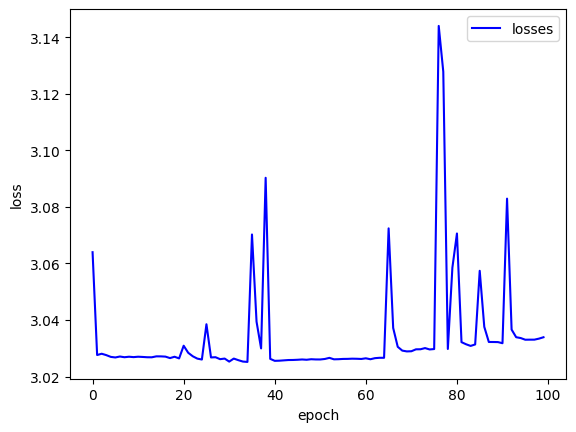

In [25]:
plot_losses(rnn_sh_losses)

### LSTM

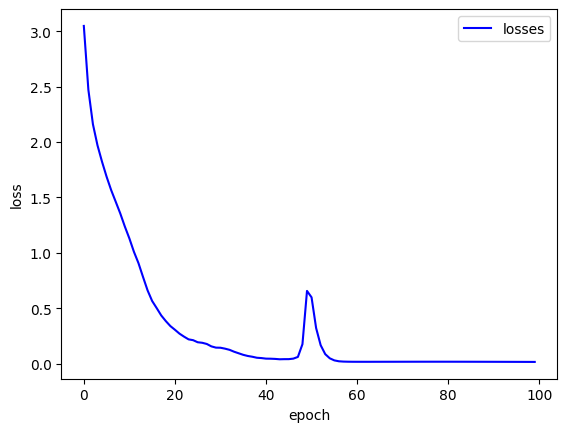

In [26]:
plot_losses(lstm_sh_losses)

## Report

According to the texts generated from different models and the losses during the training process of the models, analyze what is the reason for the difference in the result of models.

Which model works better and what do you think are the reasons?

<font color='#73FF73'><b>Your answer : </b></font> LSTMs are a more sophisticated version of RNNs and are capable of handling long-term dependencies, making them the preferred choice for many sequential data tasks. This is particularly useful in character-level text generation, where the context might span many characters.LSTMs are generally considered more effective for tasks that require learning from long sequences due to their ability to combat the vanishing gradient problem, which is a common issue in RNNs.

---
---

#2. FineTuning

FineTuning is a technique used in neural network training where a pre-trained model is further trained on a new task or dataset. It allows us to leverage the knowledge and representations learned by a pre-trained model and adapt it to a specific task or domain.

In this exercise, we first train the models with a `wikipedia` dataset that contains english texts, then we fine-tune this pre-trained model again with the Shakespeare play dataset to check the effect of this method on different models.

## Load Wikipedia dataset

In [27]:
!wget https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz

--2023-12-06 19:40:18--  https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.54.88, 16.182.39.112, 52.216.35.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.54.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070055 (3.9M) [application/x-tar]
Saving to: ‘wikitext-2.tgz’

wikitext-2.tgz      100%[===================>]   3.88M  --.-KB/s    in 0.1s    

2023-12-06 19:40:19 (26.1 MB/s) - ‘wikitext-2.tgz’ saved [4070055/4070055]



In [28]:
!tar -xvzf '/content/wikitext-2.tgz' -C '/content/data'

wikitext-2/
wikitext-2/train.csv
wikitext-2/test.csv


In [29]:
!cat './data/wikitext-2/train.csv' | tr -d '\n' > ./data/wikitext.txt

##Preprocessing

In [30]:
def clean_wiki_data(data):
    repl=''
    data=re.sub('\(', repl, data)
    data=re.sub('\)', repl, data)
    for pattern in set(re.findall("=.*=",data)):
        data=re.sub(pattern, repl, data)
    for pattern in set(re.findall("<unk>",data)):
        data=re.sub(pattern,repl,data)
    for pattern in set(re.findall(r"[^\w ]", data)):
        repl=''
        if pattern=='-':
            repl=' '
        if pattern!='.' and pattern!="\'":
            data=re.sub("\\"+pattern, repl, data)

    return data

def load_data(filepath):
    f=open(filepath)
    return f.read()

In [31]:
wikidata=load_data("./data/wikitext.txt")
data=wikidata[:]
data=clean_wiki_data(data)
wikiPreprocessed_file = open("./data/wiki_preprocesed.txt", "w")
f = wikiPreprocessed_file.write(data)
wikiPreprocessed_file.close()

- Load data in amount of 50kb for finetuning

In [32]:
wi_data_file = "./data/wiki_preprocesed.txt"
wi_data = open(wi_data_file, 'r').read(50000)

In [33]:
wi_data = remove_extraneous_characters(wi_data.lower(), chars)
wi_data_size = len(wi_data)

wi_data = list(wi_data)
for i, ch in enumerate(wi_data):
    wi_data[i] = char_to_ix[ch]

wi_data = torch.tensor(wi_data).to(device)
wi_data = torch.unsqueeze(wi_data, dim=1)

wi_data = torch.nn.functional.one_hot(wi_data[:, 0], num_classes=vocab_size).float()
wi_data = wi_data.to(device)


## Pre-training by wikipedia dataset

### RNN

In [34]:
rnn_wi_losses = train_rnn(wi_data, wi_data_size, './model_wi_rnn.pth')

Epoch 10, Loss: 2.874627365440619
Epoch 20, Loss: 2.874624903084802
Epoch 30, Loss: 2.8745434831400387
Epoch 40, Loss: 2.8744746387981976
Epoch 50, Loss: 2.8745862108762146
Epoch 60, Loss: 2.8743029021825945
Epoch 70, Loss: 2.8746595499945466
Epoch 80, Loss: 2.8745660547350274
Epoch 90, Loss: 2.874278917664387
Epoch 100, Loss: 2.8745595949595093


### LSTM

In [35]:
lstm_wi_losses = train_lstm(wi_data, wi_data_size, './model_wi_lstm.pth')

Epoch 10, Loss: 0.6473553511695783
Epoch 20, Loss: 0.3261669879687614
Epoch 30, Loss: 0.2445967225510566
Epoch 40, Loss: 0.15648724834938518
Epoch 50, Loss: 0.13560416082256152
Epoch 60, Loss: 0.14454886692835658
Epoch 70, Loss: 0.7281626724317426
Epoch 80, Loss: 0.03791240169132342
Epoch 90, Loss: 0.5283888952470706
Epoch 100, Loss: 0.07584053481028216


## Finetuning by Shakespeare

- Define the following functions to use the previous model as a pre-trained model and fine-tunes it using Shakespeare's plays dataset with lower learning rate.

In [36]:
def finetune_rnn(data, data_size, model_save_file, model_pretrained_path):
    # RNN parameters
    hidden_size = 512
    num_layers = 6
    lr = 0.001
    epoch_num = 100
    losses = []
    # In this section finetune the model that trained by wikipedia dataset with Shakespeare plays dataset
    rnn_model =  RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
    rnn_model.load_model(model_pretrained_path)
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)
    best_loss = float('inf')

    for epoch in range(1, epoch_num + 1):
        loss = train_epoch(rnn_model, data, data_size, epoch, optimizer)
        losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            torch.save(rnn_model.state_dict(), model_save_file)

    return losses

In [37]:
def finetune_lstm(data, data_size, model_save_file, model_pretrained_path):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.001
    epoch_num = 100
    losses = []
    # In this section finetune the model that trained by wikipedia dataset with Shakespeare plays dataset
    lstm_model =  LSTM(vocab_size, vocab_size, hidden_size, num_layers).to(device)
    lstm_model.load_model(model_pretrained_path)
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
    best_loss = float('inf')

    for epoch in range(1, epoch_num + 1):
        loss = train_epoch(lstm_model, data, data_size, epoch, optimizer)
        losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            torch.save(lstm_model.state_dict(), model_save_file)

    return losses

### RNN

In [38]:
rnn_sh_finetune_losses = finetune_rnn(sh_data, sh_data_size, './model_sh_finetune_rnn.pth', './model_wi_rnn.pth')

Epoch 10, Loss: 3.0045764216061297
Epoch 20, Loss: 3.0045983182972873
Epoch 30, Loss: 3.004600197693397
Epoch 40, Loss: 3.0045997389431656
Epoch 50, Loss: 3.004599255528943
Epoch 60, Loss: 3.004598928319997
Epoch 70, Loss: 3.0045986619488945
Epoch 80, Loss: 3.0045984481943067
Epoch 90, Loss: 3.00459827554637
Epoch 100, Loss: 3.0045981374280206


### LSTM

In [39]:
lstm_sh_finetune_losses = finetune_lstm(sh_data, sh_data_size, './model_sh_finetune_lstm.pth', './model_wi_lstm.pth')

Epoch 10, Loss: 0.8641388523167577
Epoch 20, Loss: 0.16258583284657577
Epoch 30, Loss: 0.04123317781707336
Epoch 40, Loss: 0.03139811616776318
Epoch 50, Loss: 0.09552237155108616
Epoch 60, Loss: 0.024822284910699415
Epoch 70, Loss: 0.4552650789762365
Epoch 80, Loss: 0.02005672926918186
Epoch 90, Loss: 0.01791305554998589
Epoch 100, Loss: 0.8532190456472594


## Plotting Losses

In [40]:
def plot_losses_together(losses1, losses2):
    xpoints = np.array(range(len(losses1)))
    ypoints1 = np.array(losses1)
    ypoints2 = np.array(losses2)

    plt.plot(xpoints, ypoints1, color='blue',label='base_losses' )
    plt.plot(xpoints, ypoints2, color='red',label='finetune_losses' )
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

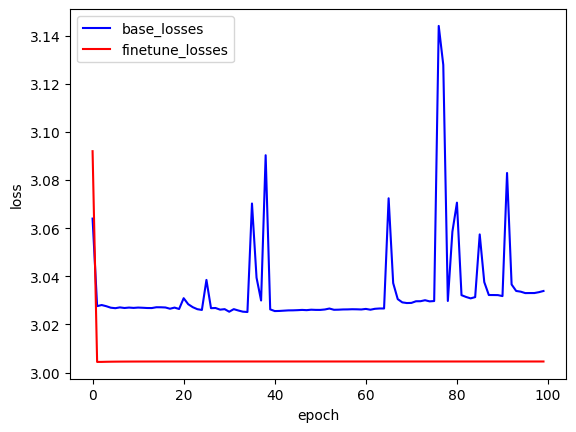

In [41]:
plot_losses_together(rnn_sh_losses, rnn_sh_finetune_losses)

### LSTM

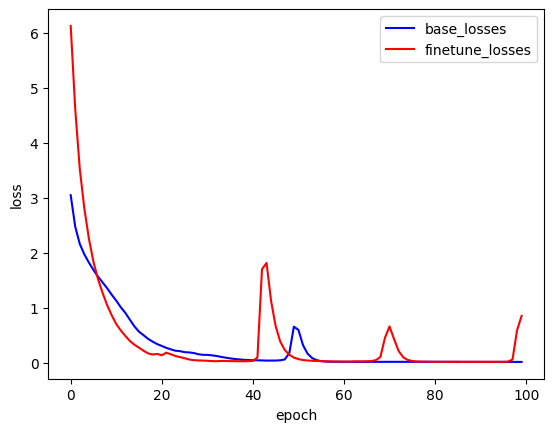

In [42]:
plot_losses_together(lstm_sh_losses, lstm_sh_finetune_losses)

## Report

As you can see, fine-tuning has an effect in improving the training of the main model.

By analyzing the obtained results, state the advantage of finetuning after pre-training the model by public dataset, and compare its performance in different models

<font color='#73FF73'><b>Your answer : </b></font> The training loss plots for both the RNN and LSTM models demonstrate a clear advantage of fine-tuning. The losses incurred during fine-tuning (depicted in red) are consistently lower than the base training losses (depicted in blue), suggesting that the models learn more effectively when fine-tuned on a specific dataset after pre-training on a larger, more general dataset.

Fine-tuning a pre-trained model offers several benefits. It leads to swift convergence as the model starts with weights that have already learned general features from a large dataset. This process enhances performance, as evidenced by lower loss values during fine-tuning, suggesting that the fine-tuned model is more proficient at modeling the target data. This is likely due to the model adjusting its pre-learned features to the specifics of the new dataset. Fine-tuning also enables efficient data utilization, allowing models to perform well even with smaller datasets, as the pre-training phase has already provided a substantial amount of knowledge that only needs minor adjustments. Lastly, fine-tuning a model that has been pre-trained on a general dataset allows the model to better adapt to the domain-specific features of the new dataset, which may be quite different from the data encountered during pre-training.

The RNN’s loss plot shows some fluctuations during fine-tuning, with occasional spikes in loss values. However, the overall trend is downward, indicating that the model is learning and adapting to the new dataset.

The LSTM’s loss plot shows a smoother and more stable fine-tuning process. The model’s ability to capture and manage long-term dependencies through its gates allows for more stable and effective fine-tuning.

----
----

#3. Experiment on different datasets

In the previous section, you saw the performance results of the text generation model using the Shakespeare plays dataset. In the following, you will check the results of the LSTM model on the dialogues of the `Friends series`

## Load dataset

In [43]:
!wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv -O ./data/Friends.csv

--2023-12-06 20:16:16--  https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5383844 (5.1M) [text/plain]
Saving to: ‘./data/Friends.csv’

./data/Friends.csv  100%[===================>]   5.13M  --.-KB/s    in 0.1s    

2023-12-06 20:16:17 (50.6 MB/s) - ‘./data/Friends.csv’ saved [5383844/5383844]



## preprocessing

In [44]:
friends = pd.read_csv('./data/Friends.csv')
friends = friends.dropna()
friends = friends[friends['speaker'].str.contains('SCENE')==False]
friends['speaker'] = friends['speaker'].apply(lambda sp: sp.lower().capitalize().split(' ')[0])
friends_texts = friends.drop(['episode','season','scene','utterance'], axis='columns')
friends_texts.head()

,text,speaker
0,There's nothing to tell! He's just some guy I ...,Monica
1,"C'mon, you're going out with the guy! There's ...",Joey
2,"All right Joey, be nice. So does he have a hum...",Chandler
3,"Wait, does he eat chalk?",Phoebe
4,"(They all stare, bemused.)",Scene


In [45]:
f = open("./data/fiends.txt", "w")
for i,row in friends_texts.iterrows():
    f.write(row['speaker'] + ':\n' + row['text'] + '\n\n')

f.close()

In [46]:
fr_data_file = "./data/fiends.txt"
fr_data = open(fr_data_file, 'r').read(30000)
fr_data = remove_extraneous_characters(fr_data.lower(), chars)
fr_data_size = len(fr_data)

fr_data = list(fr_data)
for i, ch in enumerate(fr_data):
    fr_data[i] = char_to_ix[ch]

fr_data = torch.tensor(fr_data).to(device)
fr_data = torch.unsqueeze(fr_data, dim=1)

fr_data = torch.nn.functional.one_hot(fr_data[:, 0], num_classes=vocab_size).float()
fr_data = fr_data.to(device)

## Train finetuned LSTM by friends dataset

In [47]:
lstm_fr_finetune_losses = finetune_lstm(fr_data, fr_data_size, './model_fr_lstm.pth', './model_wi_lstm.pth')

Epoch 10, Loss: 1.1512652823141405
Epoch 20, Loss: 0.21746320188879134
Epoch 30, Loss: 0.04652404443888398
Epoch 40, Loss: 1.5320243910476044
Epoch 50, Loss: 0.0347080612099254
Epoch 60, Loss: 0.02096260049204518
Epoch 70, Loss: 0.6716225337940496
Epoch 80, Loss: 0.02531304654593651
Epoch 90, Loss: 0.018846846289828523
Epoch 100, Loss: 0.02230016249264558


## Generating texts

In [48]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
print("best loss", min(lstm_fr_finetune_losses))
generate_text(best_model_lstm.to(device), fr_data.to(device), fr_data_size)

best loss 0.01826889122106864
Eaxmple of generated text --------------------------------------------------------------------------
dumnlnuummwtnll tlmmnnunnmnussmnlunulllllmlumlmmmlunmmtsstmmlulmtb tn lmm nm nsnlstwlnss mlmnumnmlnmmusmnnmumummnulmsmltmnmmlnymltu mmnlnsnnm uunslnlstmnmsllll sullllu mmlmmls msmmtmummmsmnmnnlm n mtnmummnummmlmssnmnumuu slmmlmnmntmmlmlunutmsmnlmmunnlunlm nmnsnglmlnmnlnlumnnulllunnmlullnlnmsmmummtlnnlfsmuulnssumlmmll nnlnslnullmlnlnuufmmnnnlumruumssn l ssnsummlmummu nnm  numsgmlnmmllmmslnmmmwmmnlnmllumtmnmmuunwmslgumnmsnlummmnmllllnmnnlmnmlunmusnmm unmulmlunlnmmmlullnmtmnsmmsnulnlmnluluummslmnnununmnnusmmmlllnmnuunmltnllllmssmmuullllmlunngtlmnunsn nlnnmmlnlulllmumnnmnmn rumnusutlssnlulumnnsnmmlmulmsmnnmmmmmm lmlmlnunmnhunmmnslmnmnmmmtssmummuuumllnls msumcnmlmnlltsllnllsynlnmmnunurlmmlll smnumtunmnnmtmlnnnmlm lnmlmumltmnm mtnnmnnmulnsnullnmmt sulmunmlunnmhlnll nmmsmlmnmnuslnlulunmlnmmuustmnmnsulnu mlhms lnsltsmllunmmnlnmmmutnmrlmmmmmmmnlssmslulmmsmulmwmnlmnn

- As you can see, the LSTM network has been able to learn the features of different datasets in terms of sentence length and writing style and use it in text generation.

## The output of finetuned models on different datasets on the input sample

- In this section, you can see the result of the text generated by models with a sample input text.

In [49]:
input_sample_text = "Hello, have a nice day.\n"

In [64]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
generate_text(best_model_lstm.to(device), fr_data.to(device), fr_data_size, create_input_sample_dataset(input_sample_text),100)

Eaxmple of generated text --------------------------------------------------------------------------
rmlmnmnslmulsmunnsmnnnlgmnlnunns.tssnsnn nl mgnlmnstnlswlmlmuusmmrn l lulmnumuslnn mnmuuunssnlmmllusl
----------------------------------------------------------------------------------------------------


In [65]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_finetune_lstm.pth')
generate_text(best_model_lstm, sh_data, sh_data_size, create_input_sample_dataset(input_sample_text),100)

Eaxmple of generated text --------------------------------------------------------------------------
amlilccrgrlb nllngb lgrlignlnbglnbilillbbcnlcrrlll nnllrg lggigclngr llrnlbingn nlnlgrlnrnnlinlgrlbrg
----------------------------------------------------------------------------------------------------


## Report

According to the sample input and output produced by the fine-tuned model with the Shakespeare dataset and the Friends dataset, which output is more meaningful and what is the reason for this difference?

<font color='#73FF73'><b>Your answer : </b></font> In comparing the outputs of fine-tuned RNN and LSTM models using Shakespeare and Friends datasets, the LSTM model’s output seems more structured. Despite both models’ struggle to form coherent sentences, the LSTM model maintains some structure and word integrity.

The LSTM model’s superior output can be attributed to its architecture, which is better at capturing long-term dependencies in text, allowing it to produce more structured language patterns. Additionally, LSTM models are better at generalizing from training data, making them more adaptable to new datasets.

The complexity of the Shakespeare dataset, with its archaic language and intricate sentence structures, might have helped the LSTM model to form more complex patterns, resulting in richer linguistic outputs. On the other hand, the colloquial and less structured language in the Friends dataset might have posed a challenge for the RNN model.

Moreover, the depth of fine-tuning could also play a role. If the models were not fine-tuned with enough data or epochs, they might not have adequately adapted to the new dataset. In such cases, the LSTM model’s ability to retain information across longer sequences could provide an advantage.

To sum up, the LSTM model’s output is more meaningful due to its architecture’s ability to better adapt to new datasets and retain linguistic structure, particularly when transitioning from a complex dataset like Shakespeare’s plays to a more colloquial and varied dataset like the Friends dialogues.

----
----